In [1]:
%load_ext autotime

In [2]:
import os
import pandas as pd
import numpy as np

from astroplan import Observer
from astroplan import is_observable, is_event_observable
from astropy.coordinates import SkyCoord, EarthLocation
from astropy import units as u
from astropy.time import Time

from astroplan import (AltitudeConstraint, AirmassConstraint,
                       AtNightConstraint)
from astroplan import EclipsingSystem
from astroplan.plots import plot_airmass
from matplotlib import pyplot as plt

from piaa.utils import helpers
from piaa.utils import postgres as db
from IPython import display

time: 2.62 s


#### Unit Information

Get the unit information from the database

In [3]:
meta_cursor = db.get_cursor(db_name='metadata', db_user='panoptes', port=5432)
tess_cursor = db.get_cursor(db_name='v6', db_user='postgres', port=5433)

time: 486 ms


In [4]:
meta_cursor.execute('SELECT * FROM units;')
units = meta_cursor.fetchall()

time: 79.9 ms


In [5]:
observers = list()
for unit in units:
    observer = Observer(
        latitude=unit['lat'], 
        longitude=unit['lon'], 
        elevation=unit['elevation'] * u.meter,
        timezone=unit['timezone'],
        name=unit['name']
    )
    observers.append(observer)

time: 167 ms


#### Gather Objects of Interest

In [7]:
fn = 'toi-plus-2018-10-16.csv'

time: 668 µs


In [8]:
toi = pd.read_csv(fn, index_col=['toi_id'])

time: 13.9 ms


In [9]:
toi.head()

,src,tic_id,Disposition,RA,Dec,Tmag,Tmag Err,Epoc,Epoc Err,Period,...,Centroid offset,Master,SG1a,SG1b,SG2,SG3,SG4,SG5,Created,Updated
toi_id,,,,,,,,,,,,,,,,,,,,,
174.01,spoc,425997655,PC,55.459877,-62.767049,8.69687,0.018031,1360.663220,0.001969,17.666975,...,False,2,4,1,1,4,4,4,2018-10-11 19:07:06.446607+00:00,2018-10-11 19:12:24.912927+00:00
175.03,spoc,307210830,PC,124.531900,-68.313000,9.39300,0.009000,1354.906208,0.001878,2.253014,...,False,3,4,3,3,4,4,4,2018-10-11 19:07:06.392803+00:00,2018-10-11 19:12:20.427760+00:00
175.02,spoc,307210830,PC,124.531900,-68.313000,9.39300,0.009000,1355.286400,0.001047,7.451113,...,False,2,4,1,1,4,4,4,2018-10-11 19:07:06.377334+00:00,2018-10-11 19:12:15.756260+00:00
175.01,spoc,307210830,PC,124.531900,-68.313000,9.39300,0.009000,1356.203764,0.000855,3.690613,...,False,2,4,1,1,4,4,4,2018-10-11 19:07:06.358346+00:00,2018-10-11 19:12:00.320767+00:00
119.01,spoc,278683844,PC,99.237983,-58.015237,9.23400,0.018000,1355.330268,0.002733,5.537312,...,False,2,4,1,1,4,4,4,2018-10-11 19:07:06.289913+00:00,2018-10-11 19:11:55.244725+00:00


time: 31.9 ms


In [10]:
# Coordinates for all POIs
coords = SkyCoord(ra=toi.RA, dec=toi.Dec, unit='degree')

time: 8.51 ms


In [11]:
# Set up basic constraints
constraints = [AltitudeConstraint(30*u.deg), AtNightConstraint.twilight_astronomical()]

time: 1.55 ms


In [12]:
time_range = Time(["2018-10-15 06:00", "2019-01-01 12:00"])

time: 1.37 ms


In [13]:
# Search all the available coords at each location to see when observable.
for observer in observers:
    toi['{}_observable'.format(observer.name)] = is_observable(
        constraints, observer, coords, time_range=time_range)
#     toi['{}_observable'.format(name)] = observer.target_is_up(time_range, coords, horizon=-18 * u.deg)

time: 21.7 s


In [14]:
bjd = 2457000

time: 612 µs


In [15]:
n_transits = 50

time: 21.7 ms


In [16]:
transits = list()
for toi_id, row in toi.iterrows():
    
    ticid = row['tic_id']
    
    # Lookup star info
    star_info = helpers.get_star_info(picid=ticid, cursor=tess_cursor)
    if star_info is None:
        continue
         
    # Build transit info
    primary_eclipse_time = Time(bjd + row.Epoc, format='jd')
    orbital_period = row.Period * u.day
    eclipse_duration = row.Duration * u.hour
    system = EclipsingSystem(primary_eclipse_time=primary_eclipse_time,
                               orbital_period=orbital_period, duration=eclipse_duration,
                               name=ticid)    
    
    upcoming_transits = system.next_primary_eclipse_time(Time.now(), n_eclipses=n_transits)
    ing_egr = system.next_primary_ingress_egress_time(Time.now(), n_eclipses=n_transits)
    target = SkyCoord(ra=row.RA, dec=row.Dec, unit='degree')

    obs_table = pd.DataFrame(index=upcoming_transits)
    
    for observer in observers:
#         observable = is_event_observable(constraints, observer, target, times=upcoming_transits)[0]
        observable = is_event_observable(constraints, observer, target, times_ingress_egress=ing_egr)[0]
        if observable.any():
            obs_table[observer.name] = observable
            obs_table['transit'] = ing_egr
            for dt in obs_table[obs_table[observer.name] == True].itertuples():
                
                local_date = dt[0].to_datetime().astimezone(tz=observer.timezone).date()
                
                transits.append((
                    observer.name, 
                    toi_id,
                    ticid, 
                    local_date,
                    dt[2][0].to_datetime(),
                    dt[0].to_datetime(), 
                    dt[2][1].to_datetime(), 
                    star_info.vmag,
                    toi.loc[toi_id]['Transit Depth'],
                    toi.loc[toi_id]['Duration'],
                ))
                        
transits = pd.DataFrame(transits, columns=[
    'unit_id', 
    'poi_id',
    'picid', 
    'local_date',
    'ingress',
    'midpoint',     
    'egress',
    'vmag',
    'depth',
    'duration'
]).set_index(['unit_id', 'local_date', 'poi_id']).sort_index()        

time: 1min 49s


In [21]:
transits

picid                    ingress  \
unit_id local_date poi_id                                         
BigMac  2018-10-17 101.01  231663901 2018-10-17 10:30:42.427813   
                   136.01  410153553 2018-10-17 12:56:07.882799   
                   151.01  382302241 2018-10-17 14:31:44.688013   
        2018-10-18 134.01  234994474 2018-10-18 14:16:03.343813   
                   136.01  410153553 2018-10-18 11:09:18.730799   
                   148.01  393940766 2018-10-18 11:42:47.592001   
        2018-10-20 128.01  391949880 2018-10-20 13:47:36.648584   
                   147.01  220435095 2018-10-20 15:35:12.048009   
                   152.01  403287048 2018-10-20 11:03:20.736000   
                   157.01  140691463 2018-10-20 11:25:40.224007   
        2018-10-21 114.01   25155310 2018-10-21 10:55:23.548807   
                   124.01   29831208 2018-10-21 15:02:38.502580   
                   169.01  183120439 2018-10-21 15:22:47.279971   
        2018-10-22 136.01  410153553 2018-10-22 15:08:37.546821   
                   137.01  176957796 2018-10-22 13:09:14.983217   
                   140.01  140068425 2018-10-22 13:46:52.120199   
                   157.01  140691463 2018-10-22 13:27:27.072002   
        2018-10-23 106.01   38846515 2018-10-23 11:59:42.543567   
                   124.01   29831208 2018-10-23 11:16:25.580988   
                   136.01  410153553 2018-10-23 13:21:48.394821   
        2018-10-24 105.01  144065872 2018-10-24 12:24:48.610795   
                   136.01  410153553 2018-10-24 11:34:59.242821   
                   157.01  140691463 2018-10-24 15:29:13.919998   
                   177.01  262530407 2018-10-24 12:58:42.634202   
        2018-10-25 128.01  391949880 2018-10-25 12:22:09.931793   
                   134.01  234994474 2018-10-25 14:26:34.495811   
                   136.01  410153553 2018-10-25 09:48:10.090822   
                   151.01  382302241 2018-10-25 14:16:07.248036   
                   161.01  348770361 2018-10-25 11:35:33.863997   
                   167.01  149990841 2018-10-25 13:21:45.503990   
...                              ...                        ...   
        2019-09-23 175.02  307210830 2019-09-23 16:16:17.592592   
        2019-09-28 139.01   62483237 2019-09-28 13:43:30.016206   
        2019-10-10 174.01  425997655 2019-10-10 10:42:34.162194   
        2019-10-21 133.01  219338557 2019-10-21 11:30:09.815383   
        2019-10-22 178.02  251848941 2019-10-22 12:43:05.757610   
        2019-10-23 153.01  231081369 2019-10-23 14:48:58.175990   
        2019-10-24 130.01  263003176 2019-10-24 12:00:35.085587   
        2019-10-26 176.01  272086159 2019-10-26 13:22:19.198194   
        2019-11-04 125.02   52368076 2019-11-04 11:08:26.078982   
        2019-11-15 156.01  220518305 2019-11-15 11:14:19.607984   
        2019-11-22 125.02   52368076 2019-11-22 13:02:43.112399   
        2019-12-02 174.01  425997655 2019-12-02 10:43:54.082219   
        2020-01-24 174.01  425997655 2020-01-24 10:45:14.002204   
        2020-01-31 176.01  272086159 2020-01-31 11:46:32.388609   
        2020-02-16 176.01  272086159 2020-02-16 15:30:34.586991   
        2020-05-07 176.01  272086159 2020-05-07 10:10:45.578983   
        2020-05-26 130.01  263003176 2020-05-26 14:23:01.773609   
        2020-07-08 130.01  263003176 2020-07-08 14:51:31.111189   
        2020-07-29 121.01  207081058 2020-07-29 12:05:40.471821   
        2020-09-07 156.01  220518305 2020-09-07 14:17:58.199999   
        2020-09-13 176.01  272086159 2020-09-13 16:03:03.166203   
        2020-10-15 174.01  425997655 2020-10-15 10:51:53.602209   
        2020-12-03 176.01  272086159 2020-12-03 10:43:14.158195   
        2020-12-07 174.01  425997655 2020-12-07 10:53:13.522194   
        2020-12-19 176.01  272086159 2020-12-19 14:27:16.356577   
        2021-01-29 174.01  425997655 2021-01-29 10:54:33.442179   
PAN001  2018-11-03 178.01  251848941 2018-11-03 06:37:54.998403   
        201

time: 58.9 ms


In [17]:
oct_transits = transits.loc[
    pd.to_datetime(transits.index.get_level_values(1)) < Time('2018-11-01').datetime
]

time: 5.34 ms


In [19]:
hip65 = oct_transits.loc[oct_transits.picid == 201248411]

time: 14.2 ms


In [23]:
pan008_oct = oct_transits.loc[np.logical_and(oct_transits.vmag < 13, oct_transits.depth > 5000)].loc['BigMac']

time: 4.54 ms


In [24]:
pan008_oct

picid                    ingress  \
local_date poi_id                                         
2018-10-18 148.01  393940766 2018-10-18 11:42:47.592001   
2018-10-20 147.01  220435095 2018-10-20 15:35:12.048009   
           157.01  140691463 2018-10-20 11:25:40.224007   
2018-10-21 114.01   25155310 2018-10-21 10:55:23.548807   
           169.01  183120439 2018-10-21 15:22:47.279971   
2018-10-22 157.01  140691463 2018-10-22 13:27:27.072002   
2018-10-23 106.01   38846515 2018-10-23 11:59:42.543567   
2018-10-24 105.01  144065872 2018-10-24 12:24:48.610795   
           157.01  140691463 2018-10-24 15:29:13.919998   
2018-10-25 167.01  149990841 2018-10-25 13:21:45.503990   
2018-10-26 117.01  322307342 2018-10-26 13:15:18.360002   
2018-10-27 116.01  238176110 2018-10-27 11:50:44.860183   
           147.01  220435095 2018-10-27 11:53:54.096010   
2018-10-28 110.01  281459670 2018-10-28 12:55:49.871993   
2018-10-29 156.01  220518305 2018-10-29 10:43:55.704017   
2018-10-30 169.01  183120439 2018-10-30 15:57:07.056004   
           170.01  394698182 2018-10-30 11:06:20.808006   
2018-10-31 102.01  149603524 2018-10-31 13:32:15.532799   

                                    midpoint                     egress  \
local_date poi_id                                                         
2018-10-18 148.01 2018-10-18 13:19:14.591996 2018-10-18 14:55:41.591987   
2018-10-20 147.01 2018-10-20 16:33:42.048009 2018-10-20 17:32:12.047993   
           157.01 2018-10-20 12:19:18.623994 2018-10-20 13:12:57.023976   
2018-10-21 114.01 2018-10-21 12:37:55.516804 2018-10-21 14:20:27.484806   
           169.01 2018-10-21 15:56:48.479987 2018-10-21 16:30:49.679996   
2018-10-22 157.01 2018-10-22 14:21:05.471994 2018-10-22 15:14:43.872011   
2018-10-23 106.01 2018-10-23 13:53:23.913580 2018-10-23 15:47:05.283569   
2018-10-24 105.01 2018-10-24 13:50:53.577598 2018-10-24 15:16:58.544385   
           157.01 2018-10-24 16:22:52.319994 2018-10-24 17:16:30.720007   
2018-10-25 167.01 2018-10-25 14:26:40.703998 2018-10-25 15:31:35.903979   
2018-10-26 117.01 2018-10-26 14:50:29.759987 2018-10-26 16:25:41.160004   
2018-10-27 116.01 2018-10-27 13:01:44.486400 2018-10-27 14:12:44.112586   
           147.01 2018-10-27 12:52:24.096009 2018-10-27 13:50:54.095994   
2018-10-28 110.01 2018-10-28 14:19:05.980792 2018-10-28 15:42:22.089611   
2018-10-29 156.01 2018-10-29 12:36:52.703998 2018-10-29 14:29:49.704005   
2018-10-30 169.01 2018-10-30 16:31:08.255987 2018-10-30 17:05:09.455989   
           170.01 2018-10-30 12:28:45.408014 2018-10-30 13:51:10.007998   
2018-10-31 102.01 2018-10-31 15:25:13.036782 2018-10-31 17:18:10.540789   

                     vmag    depth duration  
local_date poi_id                            
2018-10-18 148.01  12.398  5029.02    3.215  
2018-10-20 147.01  12.568  9683.96     1.95  
           157.01  12.725  13291.3    1.788  
2018-10-21 114.01  10.994  7109.15  3.41776  
           169.01  12.355  6550.06    1.134  
2018-10-22 157.01  12.725  13291.3    1.788  
2018-10-23 106.01  10.798  7472.31  3.78965  
2018-10-24 105.01  10.092  11836.7  2.86943  
           157.01  12.725  13291.3    1.788  
2018-10-25 167.01  12.319  8618.88    2.164  
2018-10-26 117.01  12.312  6242.33    3.173  
2018-10-27 116.01  11.980  16879.4  2.36646  
           147.01  12.568  9683.96     1.95  
2018-10-28 110.01  12.283  16312.5  2.77562  
2018-10-29 156.01  10.721  18638.3    3.765  
2018-10-30 169.01  12.355  6550.06    1.134  
           170.01  12.557  12883.1    2.747  
2018-10-31 102.01  10.213  14057.9  3.76528

time: 21.2 ms


In [25]:
pan008_oct.loc[pan008_oct.picid == 235037761]

,,picid,ingress,midpoint,egress,vmag,depth,duration
local_date,poi_id,,,,,,,


time: 49.1 ms


In [26]:
active_units = transits.loc[transits.unit_id != 'BigMac']
pan008 = transits.loc[transits.unit_id == 'BigMac']

AttributeError: 'DataFrame' object has no attribute 'unit_id'

time: 14.7 ms


In [34]:
hip65

picid                    ingress  \
unit_id local_date poi_id                                         
PAN008  2018-09-13 129.01  201248411 2018-09-12 15:44:31.635599   
        2018-09-14 129.01  201248411 2018-09-13 15:17:07.529973   
        2018-09-15 129.01  201248411 2018-09-14 14:49:43.424386   
        2018-09-16 129.01  201248411 2018-09-15 14:22:19.318800   
        2018-09-17 129.01  201248411 2018-09-16 13:54:55.213173   
                   129.01  201248411 2018-09-17 13:27:31.107587   
        2018-09-18 129.01  201248411 2018-09-18 13:00:07.002001   
        2018-09-19 129.01  201248411 2018-09-19 12:32:42.896374   
        2018-09-20 129.01  201248411 2018-09-20 12:05:18.790787   
        2018-09-21 129.01  201248411 2018-09-21 11:37:54.685201   
        2018-09-22 129.01  201248411 2018-09-22 11:10:30.579574   
        2018-09-23 129.01  201248411 2018-09-23 10:43:06.473988   
        2018-09-24 129.01  201248411 2018-09-24 10:15:42.368402   
        2018-09-25 129.01  201248411 2018-09-25 09:48:18.262775   
        2018-09-26 129.01  201248411 2018-09-26 09:20:54.157189   

                                            midpoint  \
unit_id local_date poi_id                              
PAN008  2018-09-13 129.01 2018-09-12 16:07:20.841589   
        2018-09-14 129.01 2018-09-13 15:39:56.735989   
        2018-09-15 129.01 2018-09-14 15:12:32.630389   
        2018-09-16 129.01 2018-09-15 14:45:08.524789   
        2018-09-17 129.01 2018-09-16 14:17:44.419189   
                   129.01 2018-09-17 13:50:20.313589   
        2018-09-18 129.01 2018-09-18 13:22:56.207989   
        2018-09-19 129.01 2018-09-19 12:55:32.102389   
        2018-09-20 129.01 2018-09-20 12:28:07.996789   
        2018-09-21 129.01 2018-09-21 12:00:43.891189   
        2018-09-22 129.01 2018-09-22 11:33:19.785589   
        2018-09-23 129.01 2018-09-23 11:05:55.679989   
        2018-09-24 129.01 2018-09-24 10:38:31.574389   
        2018-09-25 129.01 2018-09-25 10:11:07.468789   
        2018-09-26 129.01 2018-09-26 09:43:43.363189   

                                              egress  vmag        depth  \
unit_id local_date poi_id                                                 
PAN008  2018-09-13 129.01 2018-09-12 16:30:10.047582  11.0  7050.947099   
        2018-09-14 129.01 2018-09-13 16:02:45.941995  11.0  7050.947099   
        2018-09-15 129.01 2018-09-14 15:35:21.836369  11.0  7050.947099   
        2018-09-16 129.01 2018-09-15 15:07:57.730782  11.0  7050.947099   
        2018-09-17 129.01 2018-09-16 14:40:33.625196  11.0  7050.947099   
                   129.01 2018-09-17 14:13:09.519569  11.0  7050.947099   
        2018-09-18 129.01 2018-09-18 13:45:45.413983  11.0  7050.947099   
        2018-09-19 129.01 2018-09-19 13:18:21.308396  11.0  7050.947099   
        2018-09-20 129.01 2018-09-20 12:50:57.202770  11.0  7050.947099   
        2018-09-21 129.01 2018-09-21 12:23:33.097183  11.0  7050.947099   
        2018-09-22 129.01 2018-09-22 11:56:08.991597  11.0  7050.947099   
        2018-09-23 129.01 2018-09-23 11:28:44.885970  11.0  7050.947099   
        2018-09-24 129.01 2018-09-24 11:01:20.780384  11.0  7050.947099   
        2018-09-25 129.01 2018-09-25 10:33:56.674798  11.0  7050.947099   
        2018-09-26 129.01 2018-09-26 10:06:32.569171  11.0  7050.947099   

                           duration  
unit_id local_date poi_id            
PAN008  2018-09-13 129.01   0.76067  
        2018-09-14 129.01   0.76067  
        2018-09-15 129.01   0.76067  
        2018-09-16 129.01   0.76067  
        2018-09-17 129.01   0.76067  
                   129.01   0.76067  
        2018-09-18 129.01   0.76067  
        2018-09-19 129.01   0.76067  
        2018-09-20 129.01   0.76067  
        2018-09-21 129.01   0.76067  
        2018-09-22 129.01   0.76067  
        2018-09-23 129.01   0.76067  
        2018-09-24 129.01   0.76067  
        2018-09-25 129.01   0.76067  
        2018-09-26 129.01   0.76067

time: 20 ms


In [72]:
picid = 267263253

time: 955 µs


In [45]:
# target_info = helpers.get_star_info(cursor=tess_cursor, picid=picid)
# target_coord = SkyCoord(ra=target_info.ra, dec=target_info.dec, unit='degree')

time: 894 µs


In [46]:
target_coord = SkyCoord(ra=0.18710, dec=-54.83051, unit='degree')

time: 9.29 ms


In [47]:
hip65.head()

picid                    ingress  \
unit_id local_date poi_id                                         
PAN008  2018-09-13 129.01  201248411 2018-09-12 15:44:31.635599   
        2018-09-14 129.01  201248411 2018-09-13 15:17:07.529973   
        2018-09-15 129.01  201248411 2018-09-14 14:49:43.424386   
        2018-09-16 129.01  201248411 2018-09-15 14:22:19.318800   
        2018-09-17 129.01  201248411 2018-09-16 13:54:55.213173   

                                            midpoint  \
unit_id local_date poi_id                              
PAN008  2018-09-13 129.01 2018-09-12 16:07:20.841589   
        2018-09-14 129.01 2018-09-13 15:39:56.735989   
        2018-09-15 129.01 2018-09-14 15:12:32.630389   
        2018-09-16 129.01 2018-09-15 14:45:08.524789   
        2018-09-17 129.01 2018-09-16 14:17:44.419189   

                                              egress  vmag        depth  \
unit_id local_date poi_id                                                 
PAN008  2018-09-13 129.01 2018-09-12 16:30:10.047582  11.0  7050.947099   
        2018-09-14 129.01 2018-09-13 16:02:45.941995  11.0  7050.947099   
        2018-09-15 129.01 2018-09-14 15:35:21.836369  11.0  7050.947099   
        2018-09-16 129.01 2018-09-15 15:07:57.730782  11.0  7050.947099   
        2018-09-17 129.01 2018-09-16 14:40:33.625196  11.0  7050.947099   

                           duration  
unit_id local_date poi_id            
PAN008  2018-09-13 129.01   0.76067  
        2018-09-14 129.01   0.76067  
        2018-09-15 129.01   0.76067  
        2018-09-16 129.01   0.76067  
        2018-09-17 129.01   0.76067

time: 17.2 ms


In [50]:
pan008 = observers[-1]

time: 1 ms


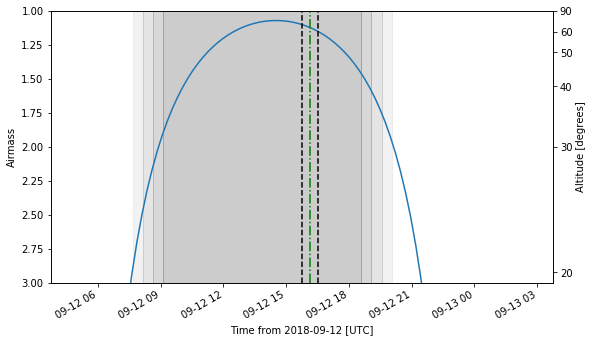

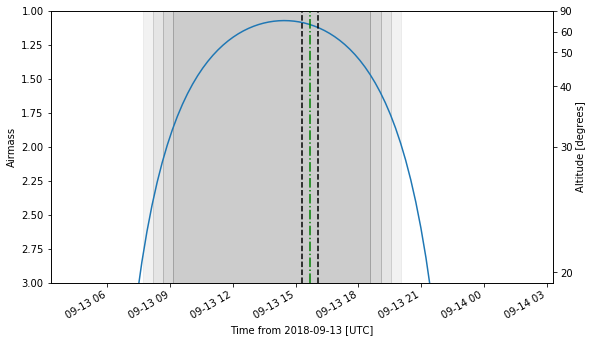

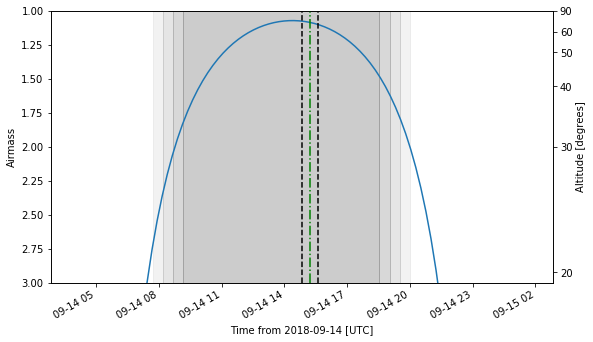

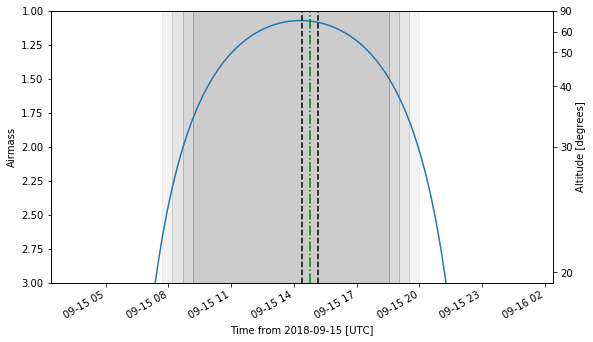

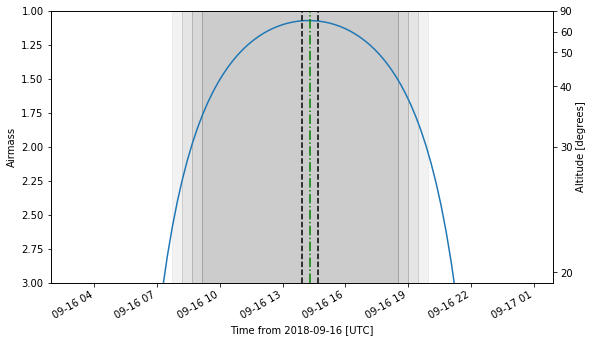

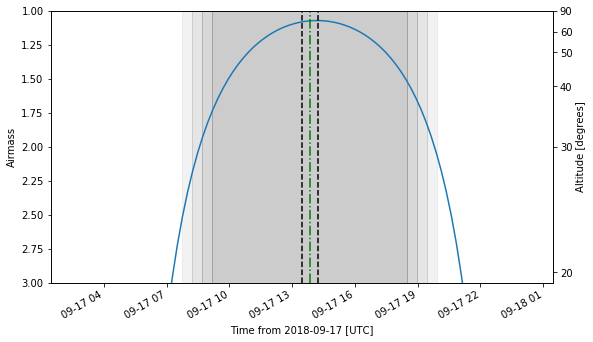

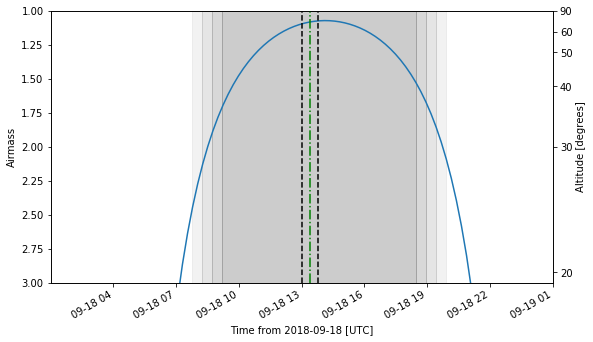

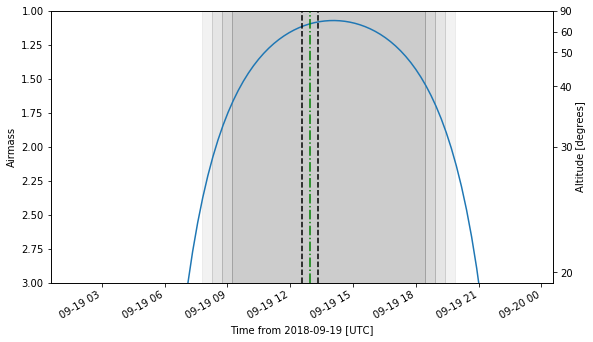

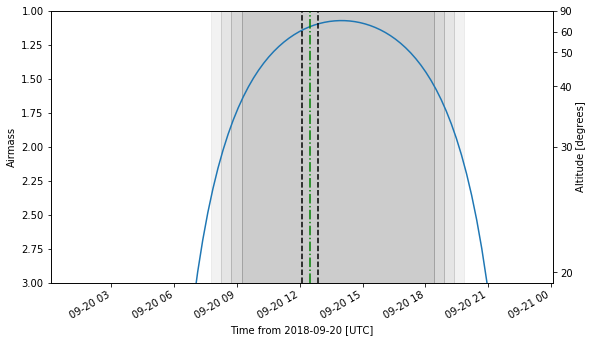

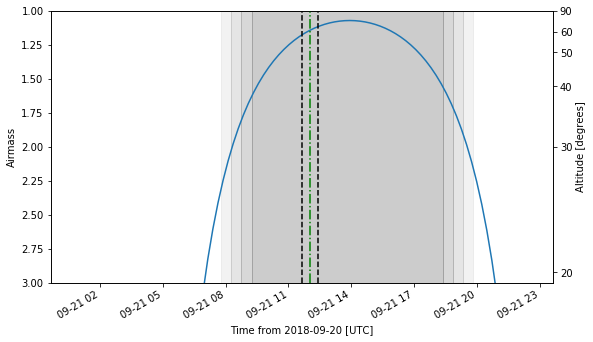

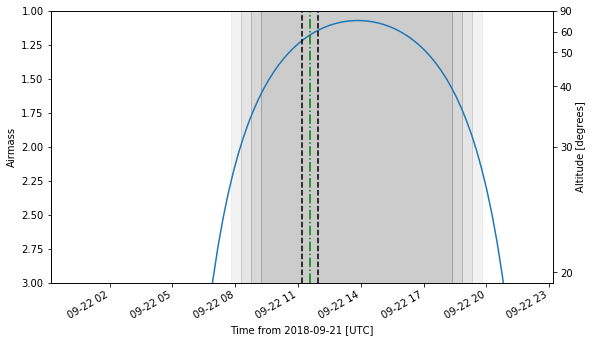

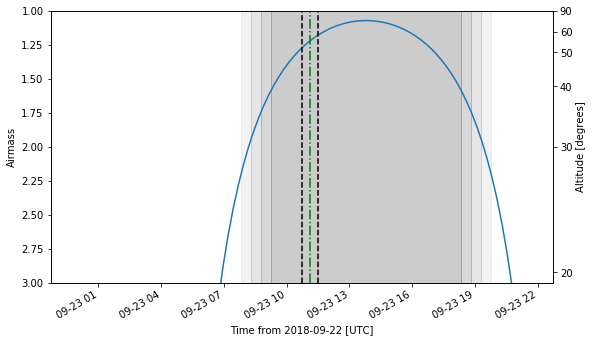

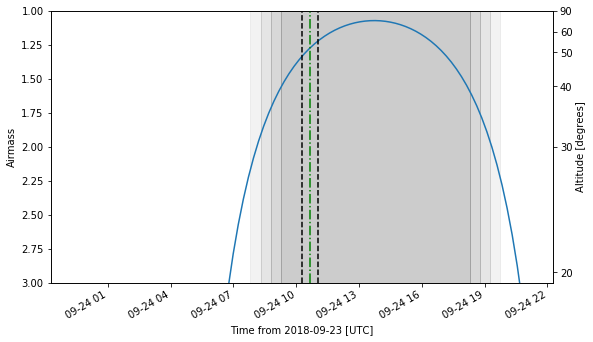

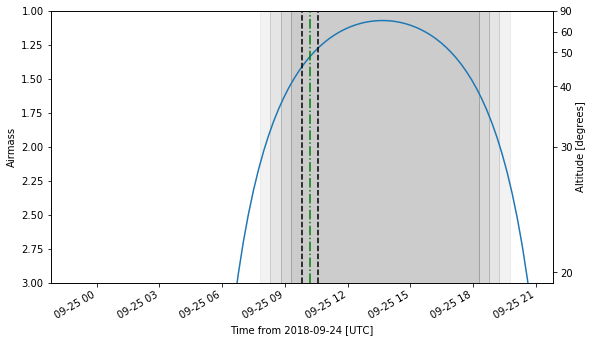

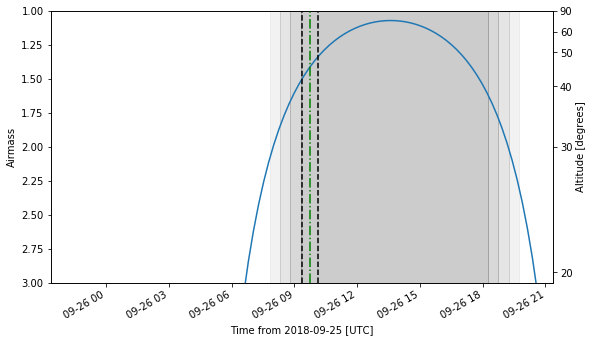

time: 24.6 s


In [53]:
for picid, row in hip65.iterrows():
#     ingress = Time(row['ingress'], format='mjd').datetime
#     midpoint = Time(row['midpoint'], format='mjd').datetime
#     egress = Time(row['egress'], format='mjd').datetime
    ingress = row.ingress
    midpoint = row.midpoint
    egress = row.egress

    plt.figure(figsize=(9, 5))
    plot_airmass(
        target_coord,
        pan008,
        ingress,
        brightness_shading=True,
        altitude_yaxis=True,
    )

    plt.axvline(midpoint, ls='-.', c='g')
    plt.axvline(ingress, ls='--', c='k')
    plt.axvline(egress, ls='--', c='k')

#     plt.title('{} {} {:.02%}'.format(
#         picid, 'x',
# #         target_info.vmag,
#         toi.loc[picid]['Transit Depth'] / 1e6)
#     )

In [63]:
pan008.head()

,unit_id,midpoint,ingress,egress,vmag
picid,,,,,
52368076,PAN008,58370.561806,58370.501125,58370.622487,11.023
410153553,PAN008,58370.591210,58370.580360,58370.602060,15.240
393940766,PAN008,58370.626230,58370.559251,58370.693209,12.398
267263253,PAN008,58370.679703,58370.586105,58370.773301,9.595
89020549,PAN008,58370.699430,58370.656340,58370.742520,11.197


time: 14.4 ms


In [75]:
tonight = pan008[Time(pan008.midpoint, format='mjd').datetime < Time('2018-09-15').datetime]

time: 6.48 ms


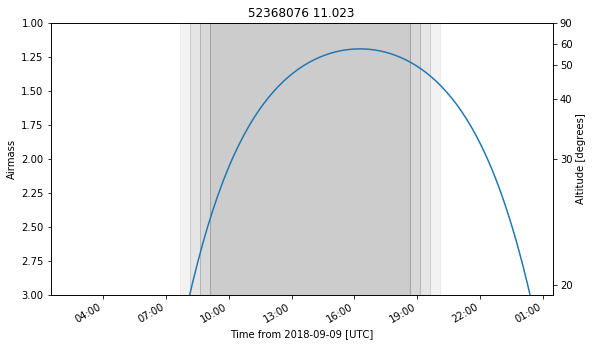

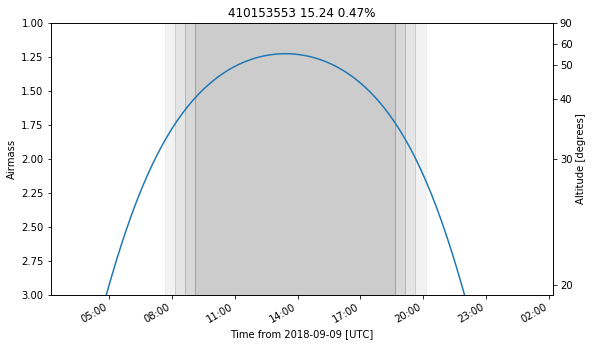

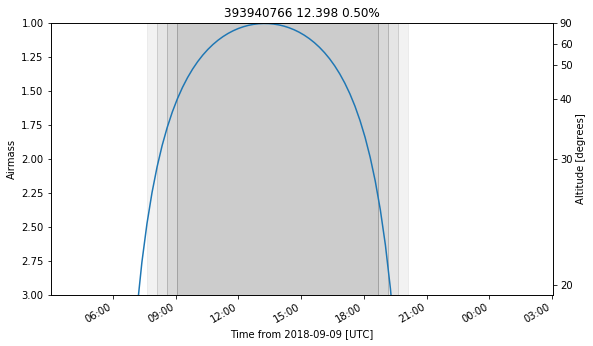

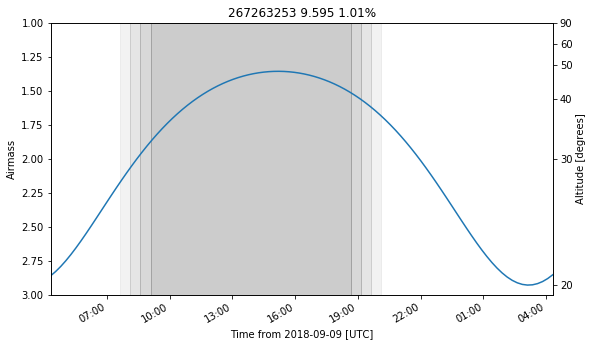

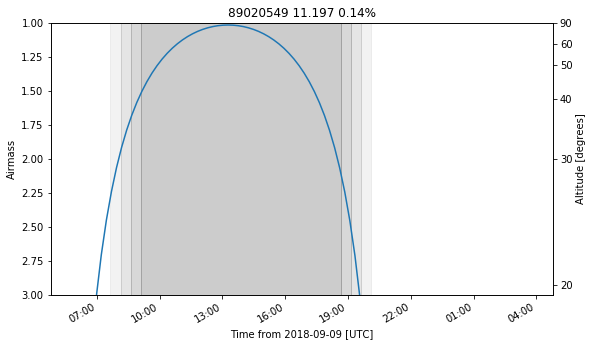

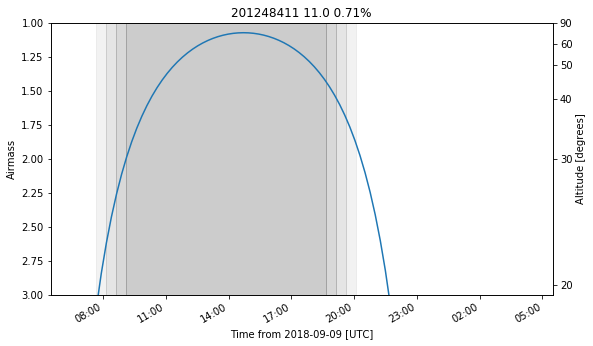

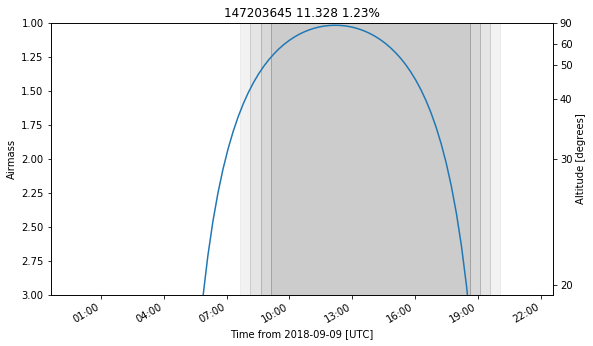

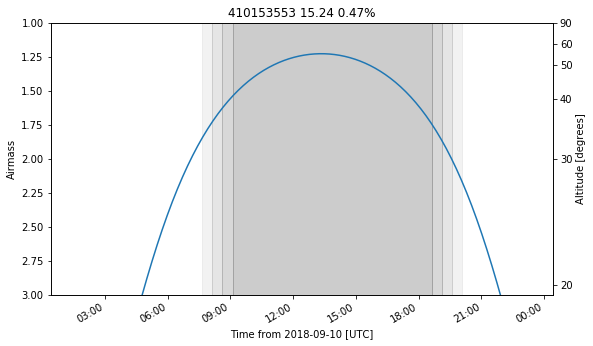

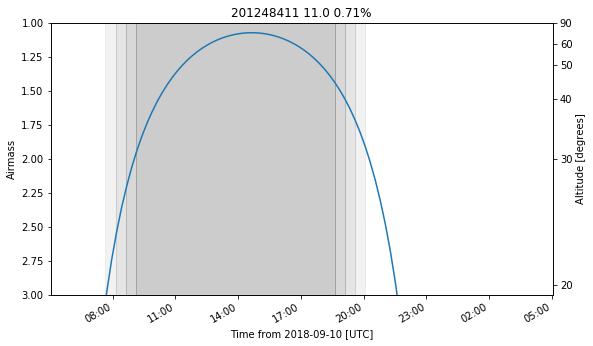

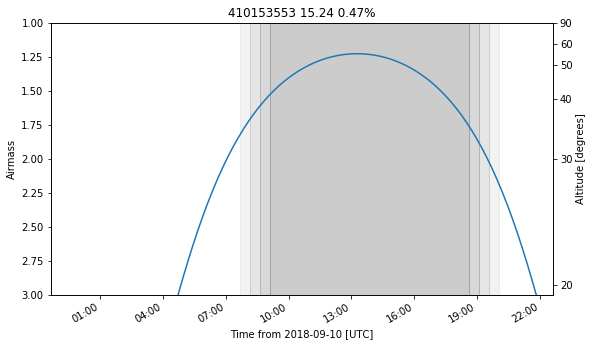

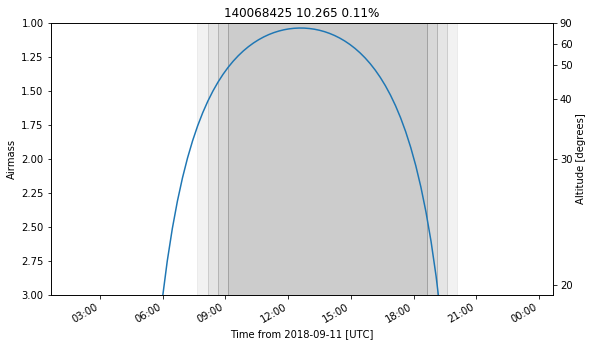

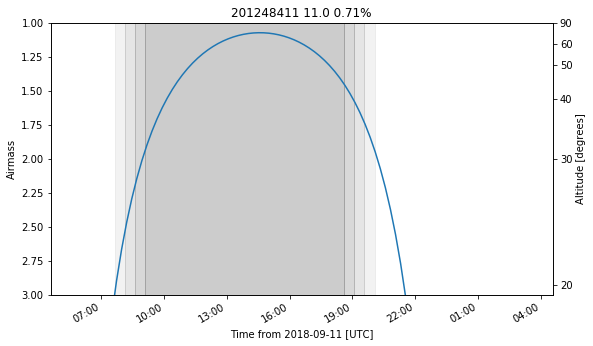

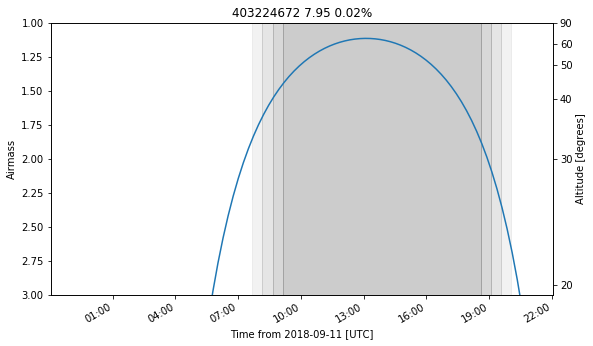

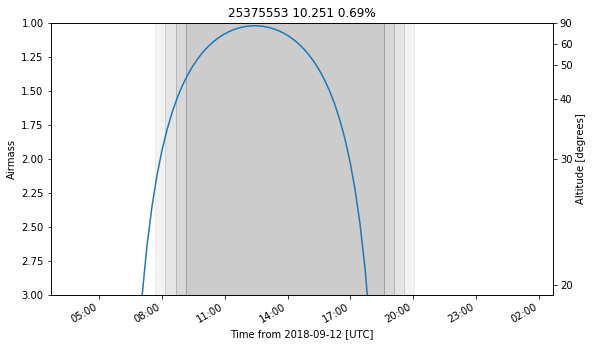

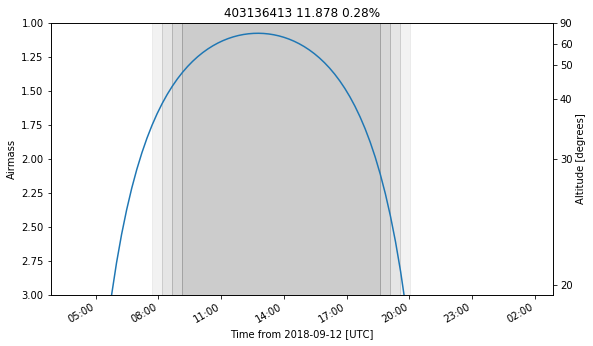

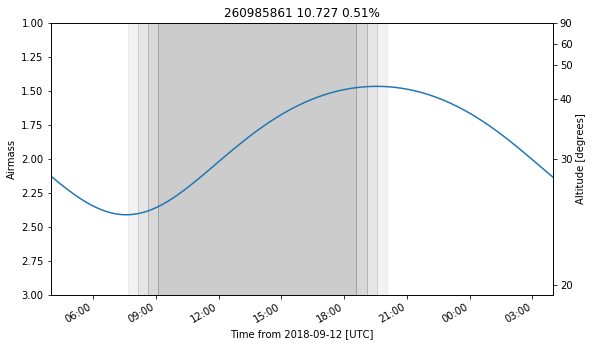

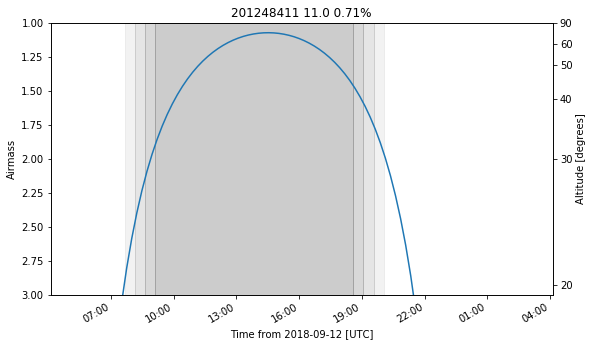

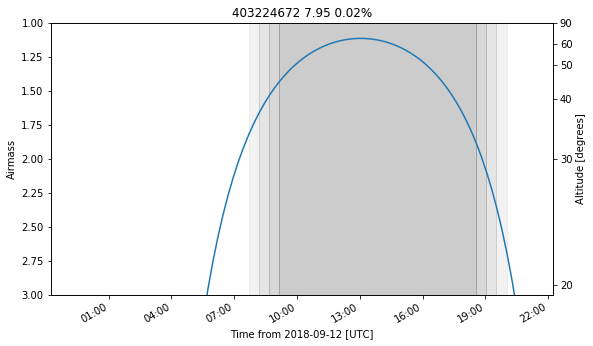

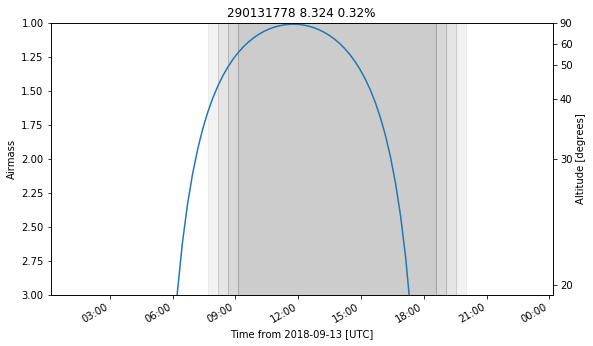

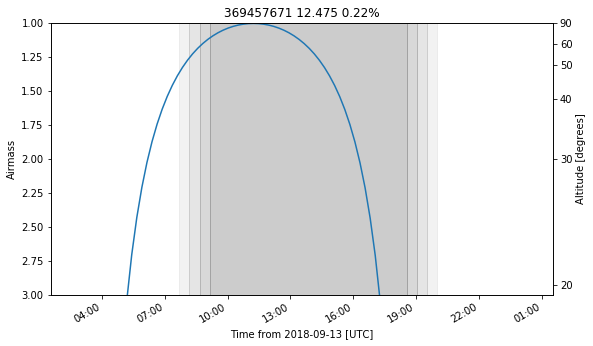

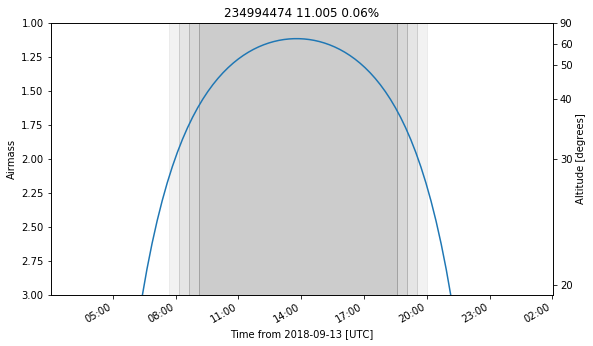

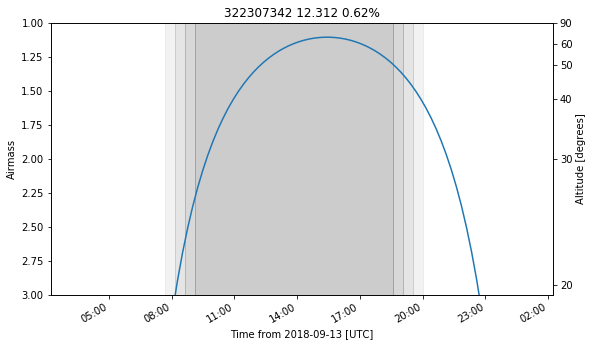

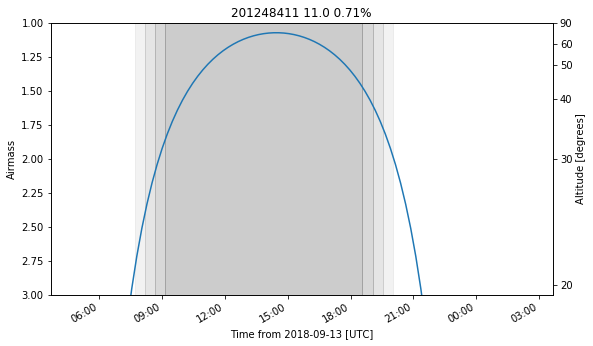

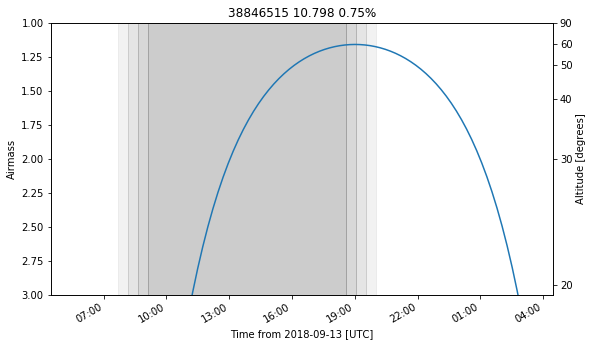

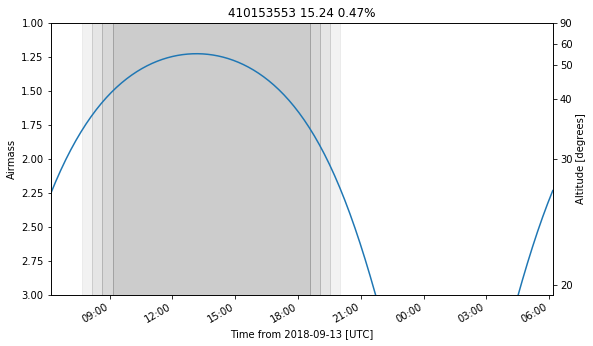

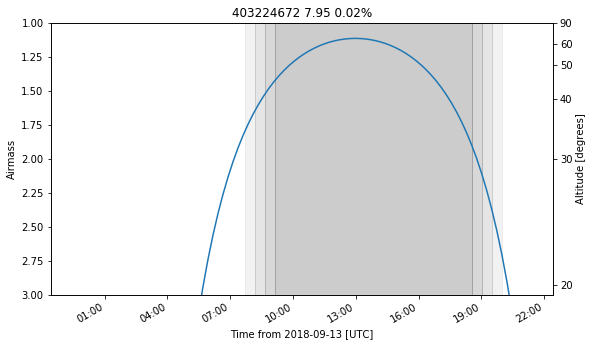

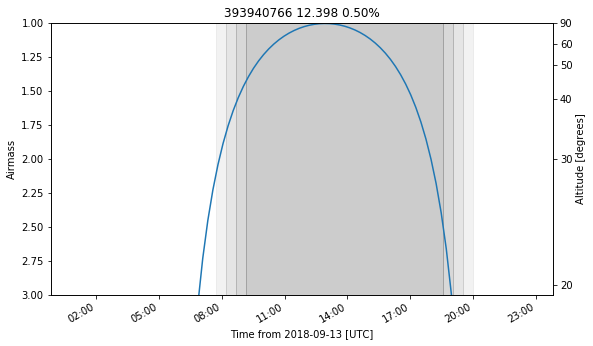

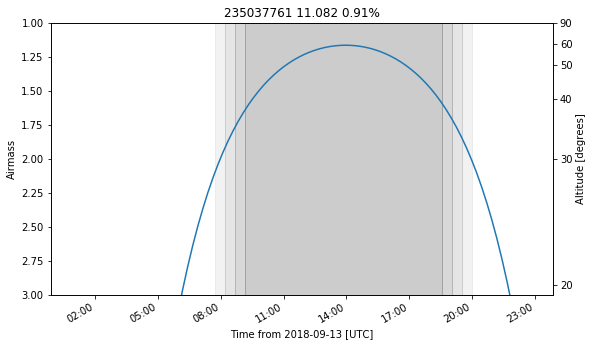

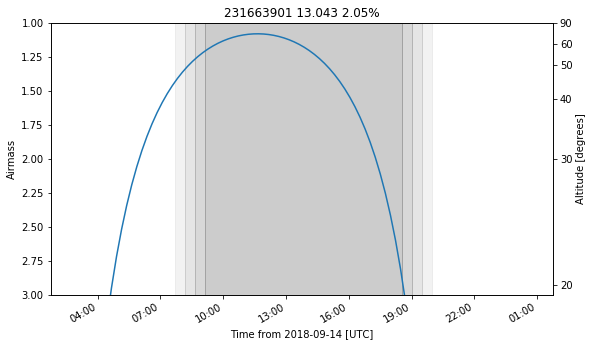

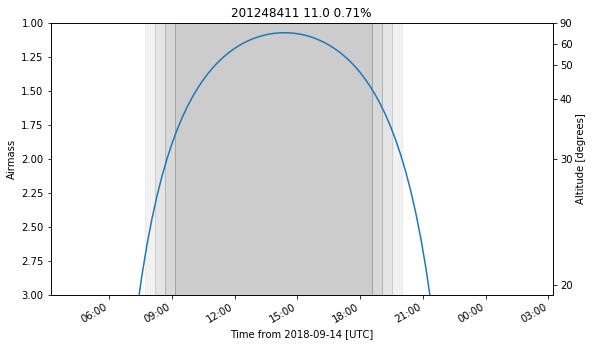

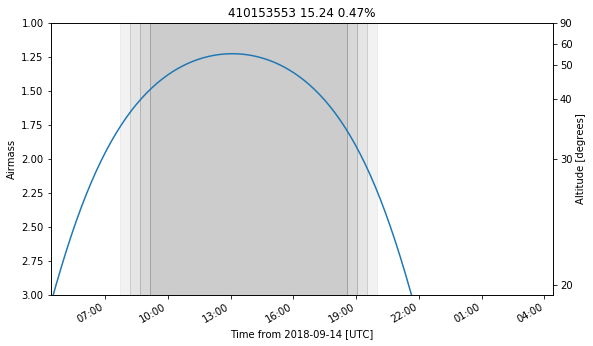

time: 51.4 s


In [77]:
for picid, row in tonight.iterrows():
    
    target_info = helpers.get_star_info(cursor=tess_cursor, picid=picid)
    target_coord = SkyCoord(ra=target_info.ra, dec=target_info.dec, unit='degree')
    
    plt.figure(figsize=(9, 5))
    plot_airmass(
        target_coord,
        locations['PAN008'],
        Time(row['midpoint'], format='mjd'),
        brightness_shading=True,
        altitude_yaxis=True,
    )
    try:
        plt.title('{} {} {:.02%}'.format(
            picid, 
            row['vmag'],
            toi.loc[picid]['Transit Depth'] / 1e6)
        )
    except TypeError:
        plt.title('{} {}'.format(
            picid, 
            row['vmag'],
        ))
    
#     plt.axvline(Time(row['midpoint'], format='mjd').datetime, ls='-.', c='g')
#     plt.axvline(Time(row['ingress'], format='mjd').datetime, ls='--', c='k')
#     plt.axvline(Time(row['egress'], format='mjd').datetime, ls='--', c='k')
    
    plt.show()

In [ ]:
tonight